The third visits were implemented on 20230710

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip
from scipy.interpolate import interp1d

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/'
wpath = '{}wfc3/'.format(path)
apath = '{}acs/'.format(path)

WFC3 first

In [4]:
drcs = glob.glob('{}*drc.fits'.format(wpath))
drcs

['/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05010_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05020_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05031_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05041_drc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05051_drc.fits']

In [5]:
flcs = glob.glob('{}*flc.fits'.format(wpath))
flcs

['/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dfq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05ddq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05deq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dgq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dhq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05diq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05djq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dkq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dpq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dtq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05duq_flc.fits',
 '/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05dwq_flc.fits']

In [6]:
eetab = Table.read('{}../wfc3uvis2_aper_007_syn.csv'.format(path))
eetab

FILTER,WAVELENGTH,APER#0.04,APER#0.08,APER#0.12,APER#0.16,APER#0.20,APER#0.24,APER#0.28,APER#0.32,APER#0.36,APER#0.40,APER#0.44,APER#0.48,APER#0.51,APER#0.55,APER#0.59,APER#0.63,APER#0.67,APER#0.71,APER#0.75,APER#0.79,APER#0.83,APER#0.87,APER#0.91,APER#0.95,APER#0.99,APER#1.03,APER#1.07,APER#1.11,APER#1.15,APER#1.19,APER#1.23,APER#1.27,APER#1.31,APER#1.35,APER#1.39,APER#1.43,APER#1.47,APER#1.50,APER#1.54,APER#1.58,APER#1.62,APER#1.66,APER#1.70,APER#1.74,APER#1.78,APER#1.82,APER#1.86,APER#1.90,APER#1.94,APER#1.98,APER#6.0
str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
FFFFF,2000.0,0.5713,0.6311,0.6845,0.7255,0.752,0.7757,0.7946,0.8086,0.8201,0.8312,0.8435,0.8558,0.8636,0.873,0.8817,0.8913,0.902,0.9129,0.9237,0.9337,0.9424,0.9499,0.9561,0.9614,0.966,0.9699,0.9733,0.9763,0.9788,0.981,0.9828,0.9843,0.9855,0.9865,0.9873,0.988,0.9886,0.989,0.9895,0.99,0.9904,0.9909,0.9913,0.9917,0.9921,0.9924,0.9928,0.9931,0.9935,0.9938,1.0
F218W,2223.7242894298383,0.5872,0.647,0.7001,0.7405,0.766,0.7886,0.8063,0.8194,0.8305,0.841,0.8521,0.863,0.8699,0.8784,0.8863,0.8949,0.9044,0.914,0.9235,0.9324,0.9401,0.9468,0.9525,0.9575,0.9618,0.9656,0.9691,0.9722,0.9749,0.9773,0.9794,0.9813,0.9828,0.9842,0.9854,0.9865,0.9874,0.988,0.9887,0.9894,0.99,0.9906,0.9911,0.9915,0.9919,0.9922,0.9926,0.9929,0.9932,0.9934,1.0
F225W,2358.3902256101073,0.6031,0.6628,0.7157,0.7555,0.78,0.8015,0.818,0.8303,0.8409,0.8508,0.8607,0.8702,0.8762,0.8838,0.8909,0.8986,0.9069,0.9152,0.9234,0.931,0.9378,0.9438,0.9489,0.9535,0.9576,0.9614,0.9648,0.968,0.9709,0.9736,0.976,0.9782,0.9802,0.9819,0.9835,0.9849,0.9862,0.987,0.988,0.9889,0.9896,0.9903,0.9909,0.9913,0.9917,0.9921,0.9924,0.9926,0.9929,0.9931,1.0
F275W,2703.297606591226,0.0639,0.295,0.5681,0.7241,0.79,0.8217,0.8389,0.8499,0.8583,0.8656,0.8722,0.8783,0.8826,0.8884,0.8946,0.9008,0.9065,0.912,0.9173,0.9225,0.9275,0.9324,0.9371,0.9417,0.9459,0.95,0.9536,0.9569,0.9599,0.9626,0.9649,0.967,0.9689,0.9705,0.972,0.9733,0.9745,0.9753,0.9764,0.9773,0.9782,0.979,0.9798,0.9805,0.9812,0.9818,0.9824,0.983,0.9835,0.984,1.0
F300X,2805.8406941029884,0.24029,0.54924,0.70461,0.77454,0.81001,0.83034,0.84388,0.85413,0.86251,0.86973,0.87606,0.88211,0.88814,0.89416,0.90025,0.90629,0.91201,0.91738,0.92268,0.92789,0.93306,0.93813,0.94289,0.94718,0.95122,0.95509,0.9588,0.9621,0.96487,0.96745,0.9698,0.97187,0.97376,0.97563,0.97718,0.97982,0.98259,0.98505,0.98564,0.98622,0.98681,0.9874,0.98799,0.98858,0.98916,0.98975,0.99034,0.99093,0.99152,0.9921,1.0
F280N,2829.9788818500247,0.27019,0.5746,0.71539,0.78092,0.81427,0.8329,0.84566,0.85563,0.86369,0.87069,0.87688,0.8818,0.88687,0.89218,0.89723,0.90212,0.90763,0.91256,0.91684,0.92161,0.92704,0.9322,0.93738,0.94274,0.94732,0.95172,0.95569,0.95976,0.96335,0.96678,0.96984,0.97276,0.97453,0.97543,0.9767,0.97964,0.98244,0.98493,0.98552,0.98612,0.98671,0.9873,0.9879,0.98849,0.98908,0.98968,0.99027,0.99087,0.99146,0.99205,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F763M,7612.744622820045,0.26773,0.55477,0.7152,0.81145,0.84248,0.85692,0.87002,0.88439,0.89693,0.90387,0.90954,0.91542,0.92223,0.92819,0.93206,0.93516,0.93845,0.94164,0.94411,0.94662,0.9492,0.95133,0.95338,0.95513,0.95628,0.9567,0.95778,0.95889,0.95942,0.95955,0.95992,0.96149,0.96251,0.96333,0.96488,0.96589,0.96691,0.96787,0.96855,0.96924,0.96992,0.9706,0.97128,0.97197,0.97265,0.97333,0.97401,0.9747,0.97538,0.97606,1.0
F775W,7648.3046091546,0.26053,0.54776,0.70804,0.80632,0.84195,0.85724,0.8703,0.88415,0.89622,0.90392,0.9

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05010_drc.fits
F275W
1770.0
   aperture_sum   
------------------
0.8978401088537856
3.704763375385067e-18 9.316014043994177e-20
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     486   751.7       0.8978          0.02252   0.00218              0.8957


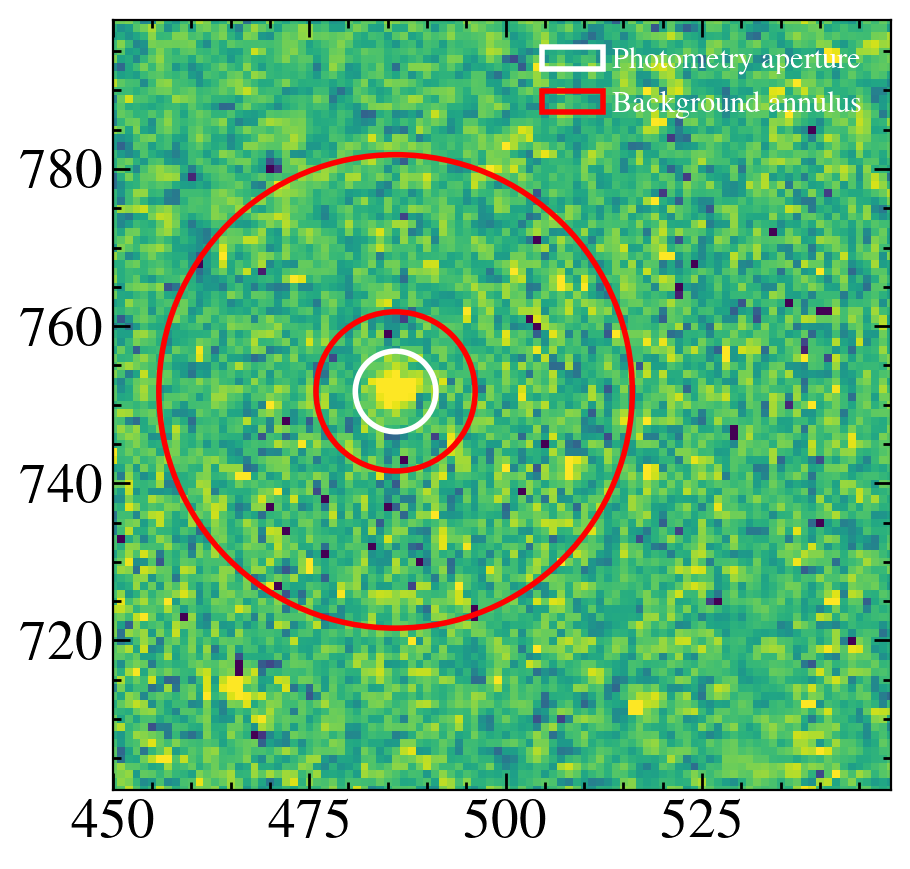

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05020_drc.fits
F280N
1770.0
   aperture_sum   
------------------
0.7375035937430953
4.634690997086207e-17 1.4834993477668363e-18
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     486   751.7       0.7375          0.02041   0.09979              0.6377


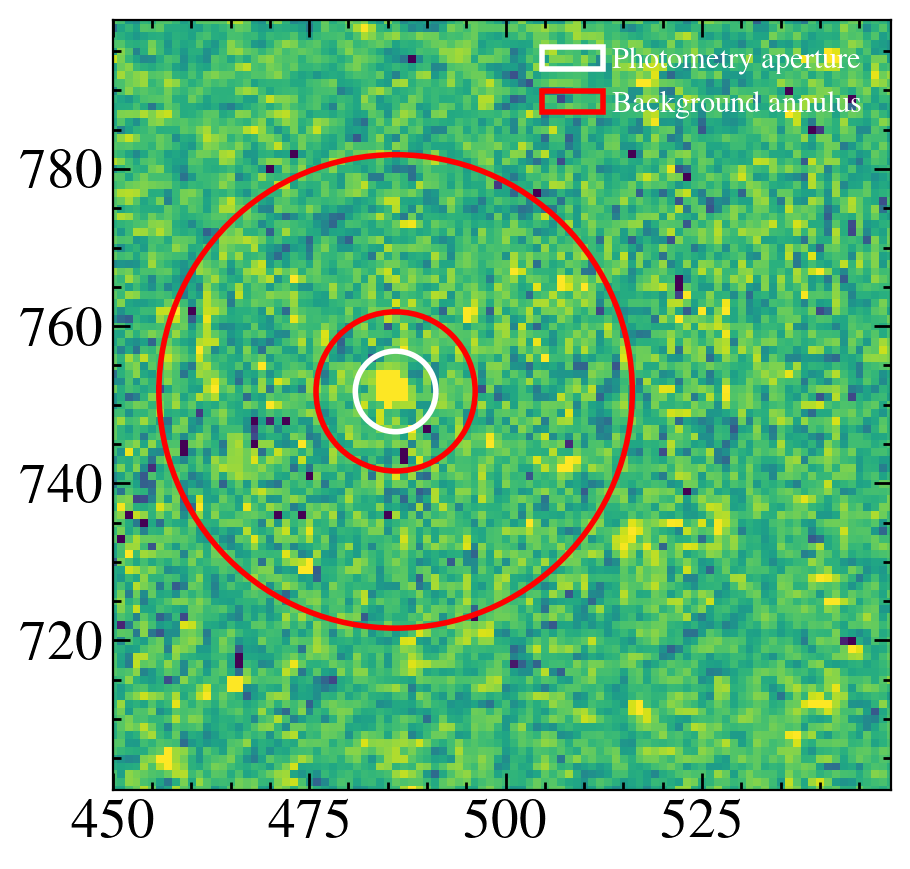

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05031_drc.fits
F225W
1180.0
   aperture_sum   
------------------
0.5964463105354519
3.544024123974302e-18 1.3408394313963187e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     486   751.7       0.5964          0.02248  0.002203              0.5942


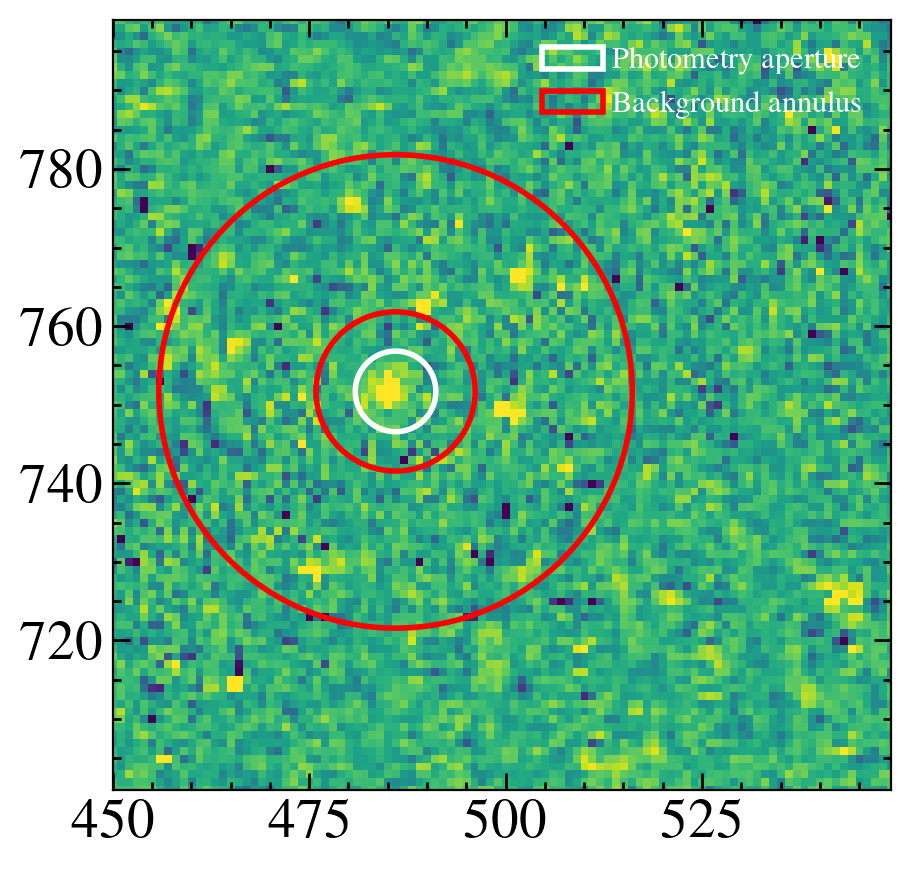

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05041_drc.fits
F225W
1180.0
   aperture_sum   
------------------
0.5476504816103552
3.2219913740714534e-18 1.2848219394469843e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     486   751.7       0.5477          0.02154  0.007404              0.5402


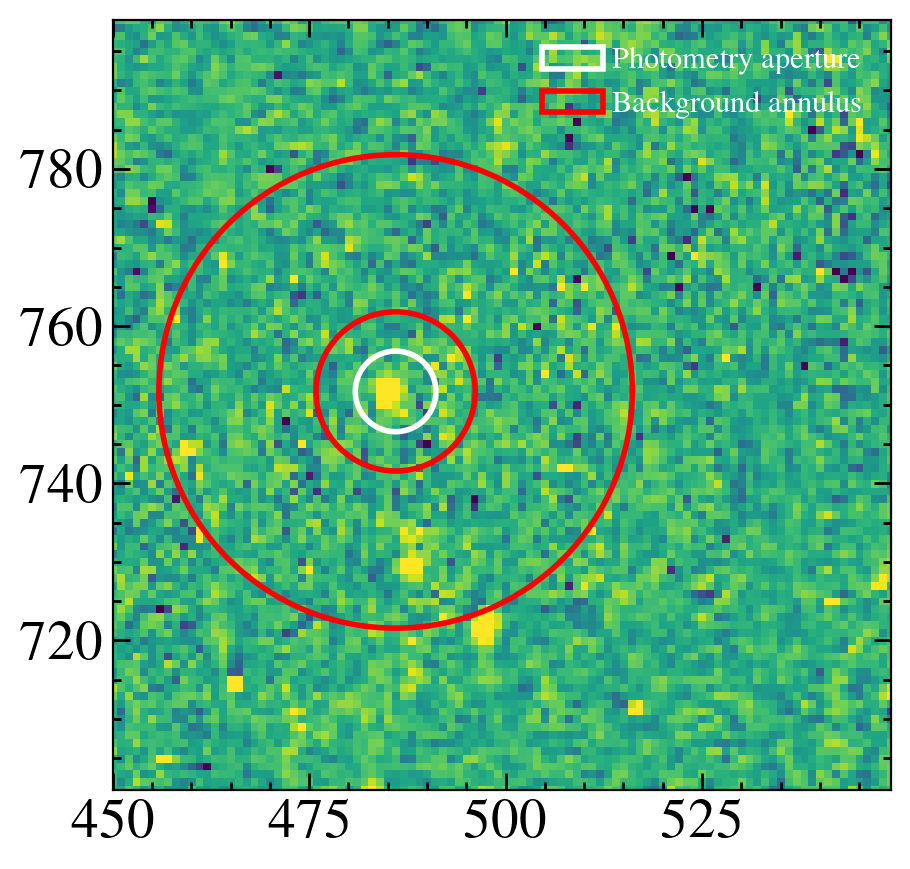

/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch3/wfc3/if3i05051_drc.fits
F225W
1180.0
    aperture_sum   
-------------------
0.44045543680577626
2.4366528455792665e-18 1.1522383238333702e-19
 id xcenter ycenter aperture_sum aperture_sum_err total_bkg aperture_sum_bkgsub
      pix     pix                                                              
--- ------- ------- ------------ ---------------- --------- -------------------
  1     486   751.7       0.4405          0.01932   0.03189              0.4086


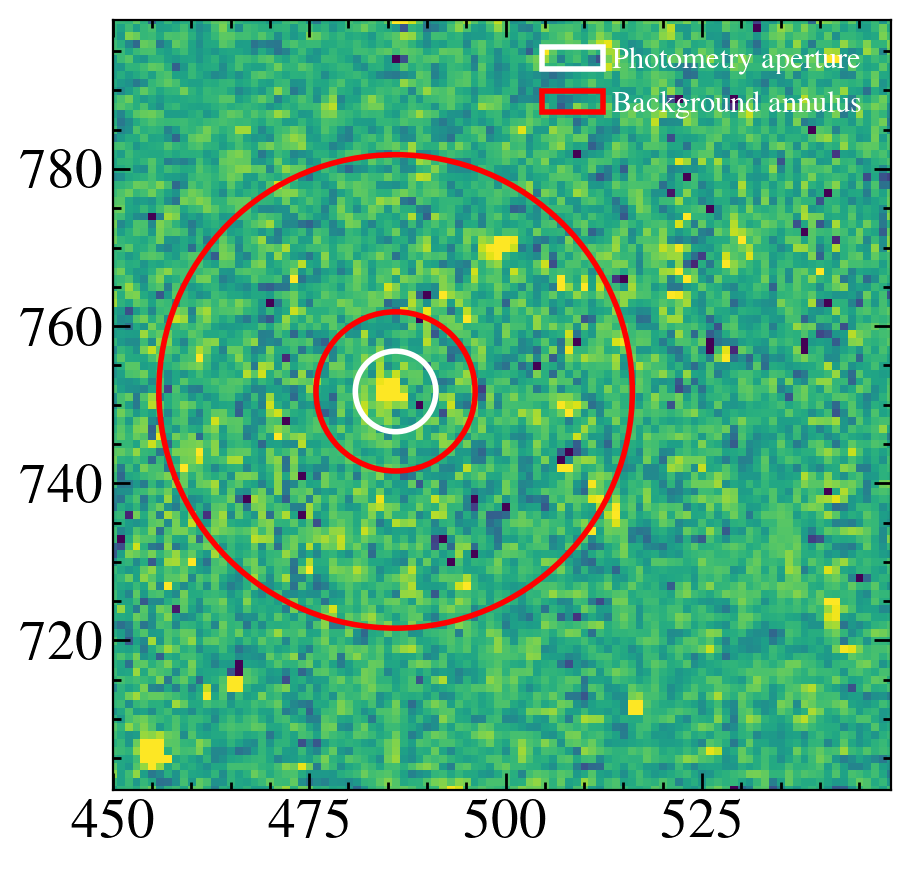

In [8]:
wfc3_pos = [(486, 751.70)]
pixscale = 0.039
ap_arc = '0.20' # aperture size in arcseconds
ap_pix = float(ap_arc)/pixscale #aperture size in pixels

filters = []
fluxes = []
flux_errs = []

# print(eetab['APER#{}'.format(ap_arc)])

# for flc in flcs:
#     print(flc)
#     hdul = fits.open(flc)
for drc in drcs:
    print(drc)
    hdul = fits.open(drc)
    filt = hdul[0].header['FILTER'] 
    print(filt)
    filters.append(filt)
    exptime = hdul[0].header['EXPTIME']
    print(exptime)
    data = hdul[1].data
    data = np.nan_to_num(data, 0.0)
#     error = hdul[2].data
#     dq = hdul[3].data
#     mask = dq != 0
#     error = np.sqrt(data*exptime)/exptime
    
    norm = simple_norm(data, 'sqrt', percent=99)
    plt.imshow(data, norm=norm, interpolation='nearest', origin='lower')
    plt.xlim(450, 549)
    plt.ylim(701, 799)
# # positions = [(515, 509), (725, 468)]



    aperture = CircularAperture(wfc3_pos, r=ap_pix)

    annulus_aperture = CircularAnnulus(wfc3_pos, r_in=ap_pix+5, r_out=ap_pix+25)

    ap_patches = aperture.plot(color='white', lw=2,
                               label='Photometry aperture')
    ann_patches = annulus_aperture.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(facecolor='#458989', labelcolor='white',
               handles=handles, prop={'weight': 'bold', 'size': 11})
    
    phot_table = aperture_photometry(data, aperture)
#     print(phot_table)
    aperture_area = aperture.area_overlap(data)
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
    total_bkg = bkg_stats.median * aperture_area
    print(phot_table['aperture_sum'])
    phot_error = ((phot_table['aperture_sum']*exptime)**0.5)/exptime#calculating error by hand
    phot_table['aperture_sum_err'] = phot_error
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.4g'  # for consistent table output
        
    ee = eetab['APER#{}'.format(ap_arc)][eetab['FILTER'] == filt][0]
#     print(ee[0])
    
    photflam = hdul[1].header['PHOTFLAM']
    
    flux = phot_table['aperture_sum_bkgsub'][0] * photflam /ee
    flux_err = phot_table['aperture_sum_err'][0]* photflam /ee
    print(flux, flux_err)
    
    fluxes.append(flux)
    flux_errs.append(flux_err)

    print(phot_table)
    
    
    
    
    
    
    

    plt.show()

In [9]:
eetab = Table.read('{}../wfc3uvis2_aper_007_syn.csv'.format(path))
eetab

FILTER,WAVELENGTH,APER#0.04,APER#0.08,APER#0.12,APER#0.16,APER#0.20,APER#0.24,APER#0.28,APER#0.32,APER#0.36,APER#0.40,APER#0.44,APER#0.48,APER#0.51,APER#0.55,APER#0.59,APER#0.63,APER#0.67,APER#0.71,APER#0.75,APER#0.79,APER#0.83,APER#0.87,APER#0.91,APER#0.95,APER#0.99,APER#1.03,APER#1.07,APER#1.11,APER#1.15,APER#1.19,APER#1.23,APER#1.27,APER#1.31,APER#1.35,APER#1.39,APER#1.43,APER#1.47,APER#1.50,APER#1.54,APER#1.58,APER#1.62,APER#1.66,APER#1.70,APER#1.74,APER#1.78,APER#1.82,APER#1.86,APER#1.90,APER#1.94,APER#1.98,APER#6.0
str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
FFFFF,2000.0,0.5713,0.6311,0.6845,0.7255,0.752,0.7757,0.7946,0.8086,0.8201,0.8312,0.8435,0.8558,0.8636,0.873,0.8817,0.8913,0.902,0.9129,0.9237,0.9337,0.9424,0.9499,0.9561,0.9614,0.966,0.9699,0.9733,0.9763,0.9788,0.981,0.9828,0.9843,0.9855,0.9865,0.9873,0.988,0.9886,0.989,0.9895,0.99,0.9904,0.9909,0.9913,0.9917,0.9921,0.9924,0.9928,0.9931,0.9935,0.9938,1.0
F218W,2223.7242894298383,0.5872,0.647,0.7001,0.7405,0.766,0.7886,0.8063,0.8194,0.8305,0.841,0.8521,0.863,0.8699,0.8784,0.8863,0.8949,0.9044,0.914,0.9235,0.9324,0.9401,0.9468,0.9525,0.9575,0.9618,0.9656,0.9691,0.9722,0.9749,0.9773,0.9794,0.9813,0.9828,0.9842,0.9854,0.9865,0.9874,0.988,0.9887,0.9894,0.99,0.9906,0.9911,0.9915,0.9919,0.9922,0.9926,0.9929,0.9932,0.9934,1.0
F225W,2358.3902256101073,0.6031,0.6628,0.7157,0.7555,0.78,0.8015,0.818,0.8303,0.8409,0.8508,0.8607,0.8702,0.8762,0.8838,0.8909,0.8986,0.9069,0.9152,0.9234,0.931,0.9378,0.9438,0.9489,0.9535,0.9576,0.9614,0.9648,0.968,0.9709,0.9736,0.976,0.9782,0.9802,0.9819,0.9835,0.9849,0.9862,0.987,0.988,0.9889,0.9896,0.9903,0.9909,0.9913,0.9917,0.9921,0.9924,0.9926,0.9929,0.9931,1.0
F275W,2703.297606591226,0.0639,0.295,0.5681,0.7241,0.79,0.8217,0.8389,0.8499,0.8583,0.8656,0.8722,0.8783,0.8826,0.8884,0.8946,0.9008,0.9065,0.912,0.9173,0.9225,0.9275,0.9324,0.9371,0.9417,0.9459,0.95,0.9536,0.9569,0.9599,0.9626,0.9649,0.967,0.9689,0.9705,0.972,0.9733,0.9745,0.9753,0.9764,0.9773,0.9782,0.979,0.9798,0.9805,0.9812,0.9818,0.9824,0.983,0.9835,0.984,1.0
F300X,2805.8406941029884,0.24029,0.54924,0.70461,0.77454,0.81001,0.83034,0.84388,0.85413,0.86251,0.86973,0.87606,0.88211,0.88814,0.89416,0.90025,0.90629,0.91201,0.91738,0.92268,0.92789,0.93306,0.93813,0.94289,0.94718,0.95122,0.95509,0.9588,0.9621,0.96487,0.96745,0.9698,0.97187,0.97376,0.97563,0.97718,0.97982,0.98259,0.98505,0.98564,0.98622,0.98681,0.9874,0.98799,0.98858,0.98916,0.98975,0.99034,0.99093,0.99152,0.9921,1.0
F280N,2829.9788818500247,0.27019,0.5746,0.71539,0.78092,0.81427,0.8329,0.84566,0.85563,0.86369,0.87069,0.87688,0.8818,0.88687,0.89218,0.89723,0.90212,0.90763,0.91256,0.91684,0.92161,0.92704,0.9322,0.93738,0.94274,0.94732,0.95172,0.95569,0.95976,0.96335,0.96678,0.96984,0.97276,0.97453,0.97543,0.9767,0.97964,0.98244,0.98493,0.98552,0.98612,0.98671,0.9873,0.9879,0.98849,0.98908,0.98968,0.99027,0.99087,0.99146,0.99205,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F763M,7612.744622820045,0.26773,0.55477,0.7152,0.81145,0.84248,0.85692,0.87002,0.88439,0.89693,0.90387,0.90954,0.91542,0.92223,0.92819,0.93206,0.93516,0.93845,0.94164,0.94411,0.94662,0.9492,0.95133,0.95338,0.95513,0.95628,0.9567,0.95778,0.95889,0.95942,0.95955,0.95992,0.96149,0.96251,0.96333,0.96488,0.96589,0.96691,0.96787,0.96855,0.96924,0.96992,0.9706,0.97128,0.97197,0.97265,0.97333,0.97401,0.9747,0.97538,0.97606,1.0
F775W,7648.3046091546,0.26053,0.54776,0.70804,0.80632,0.84195,0.85724,0.8703,0.88415,0.89622,0.90392,0.9

In [10]:
0.4/0.039

10.256410256410257

In [11]:
340e-18*1.5

5.1e-16

In [12]:
mpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/TRAPPIST-1/'

nuv = fits.getdata('{}hlsp_muscles_hst_cos_trappist-1_g230l_v10_component-spec.fits'.format(mpath), 1)
wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
mask = (wn > 2300) & (wn < 3000)
wn, fn, en = wn[mask], fn[mask], en[mask]



['F275W', 'F280N', 'F225W', 'F225W', 'F225W'] [3.704763375385067e-18, 4.634690997086207e-17, 3.544024123974302e-18, 3.2219913740714534e-18, 2.4366528455792665e-18] [9.316014043994177e-20, 1.4834993477668363e-18, 1.3408394313963187e-19, 1.2848219394469843e-19, 1.1522383238333702e-19] [39.76768775 31.24161129 26.43138351 25.07733776 21.14712551]


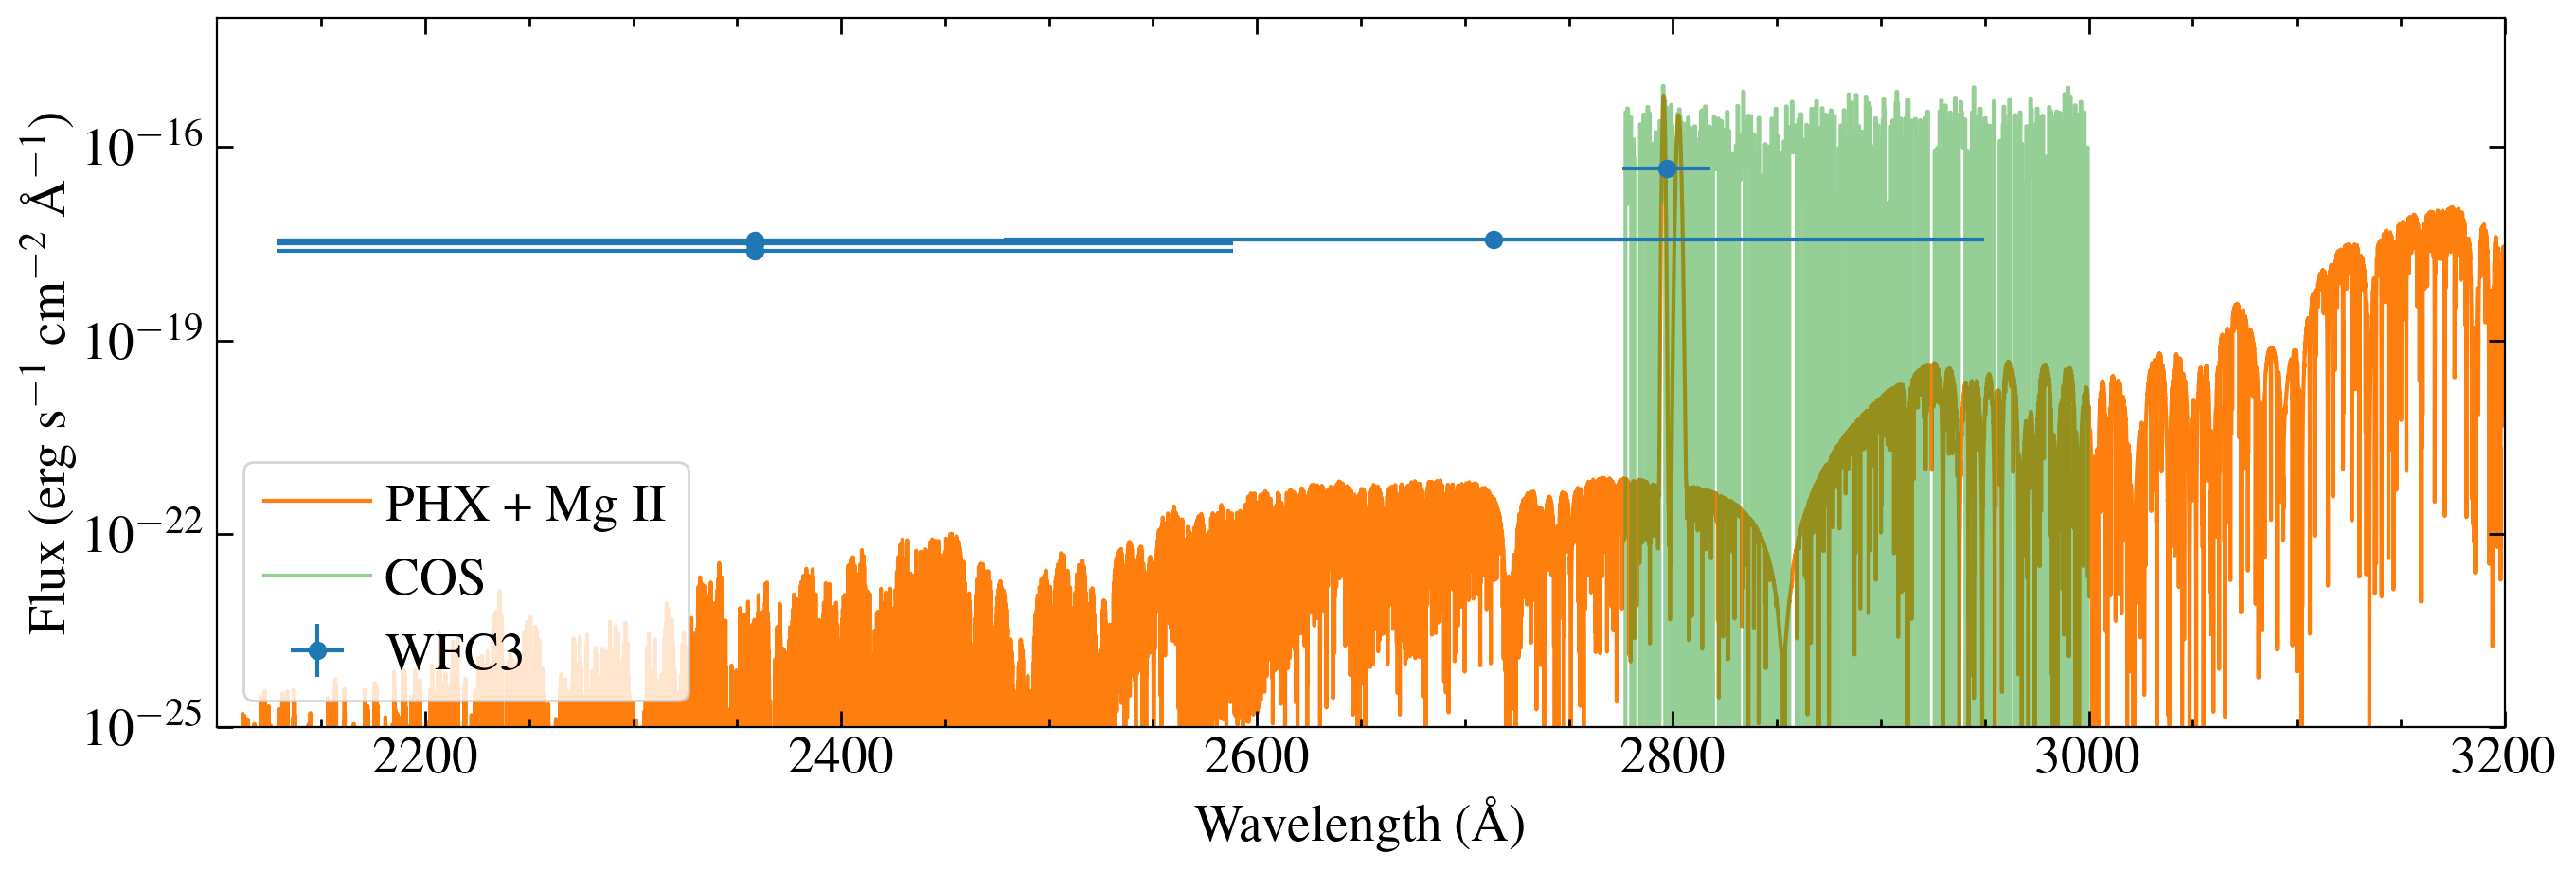

In [18]:
print(filters, fluxes, flux_errs, np.array(fluxes)/np.array(flux_errs))
cenwaves = [2713.86, 2796.94, 2358.70, 2358.70 , 2358.70]
widths = np.array([471.42, 42.16, 459.87 , 459.87 , 459.87 ])

fig, ax=plt.subplots()

w, f = np.loadtxt('t1uv_model_v2.dat', unpack=True)
plt.plot(w, f, zorder=-1, c='C1', label ='PHX + Mg II')

plt.step(wn, fn, alpha =0.5, where='mid', zorder=-1, c='C2', label='COS')
plt.errorbar(cenwaves, fluxes, yerr=flux_errs, xerr=widths/2, marker='o', ls='none', label='WFC3', zorder=10, c='C0')
 
ax.legend(frameon=True, loc=3)
    
plt.yscale('log')
plt.ylim(1e-25, 1e-14)
plt.xlim(2100, 3200)

ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')

fig.tight_layout()

savdat = Table([cenwaves*u.AA, fluxes*u.erg/u.s/u.cm**2/u.AA, flux_errs*u.erg/u.s/u.cm**2/u.AA, widths*u.AA, filters], names = ['WAVELENGTH', 'FLUX', 'ERROR', 'FWHM', 'FILTER'])
savdat.write('results/epoch3_wfc_photometry.ecsv', format='ascii.ecsv', overwrite=True)

Need to integrate the model over the fliters so I'm sure it's not just the Mg II lines... pysynphot doesn't work for python 3.10, have to do it by hand.

In [14]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

In [15]:
bands= glob.glob('filters/*UVIS*')
bands

['filters/HST_WFC3_UVIS2.F275W.dat',
 'filters/HST_WFC3_UVIS2.F225W.dat',
 'filters/HST_WFC3_UVIS2.F280N.dat']

In [16]:
phot_w = np.array([2713.86, 2358.7, 2796.94])
phot_f = []
for band in bands:
    bpw, bpf = np.loadtxt(band, unpack=True)
    phot = make_phot(bpw, bpf, w, f)
    phot_f.append(phot)
print(phot_f)

[1.791268145160082e-18, 1.5468124773685447e-19, 2.8340546061028076e-17]


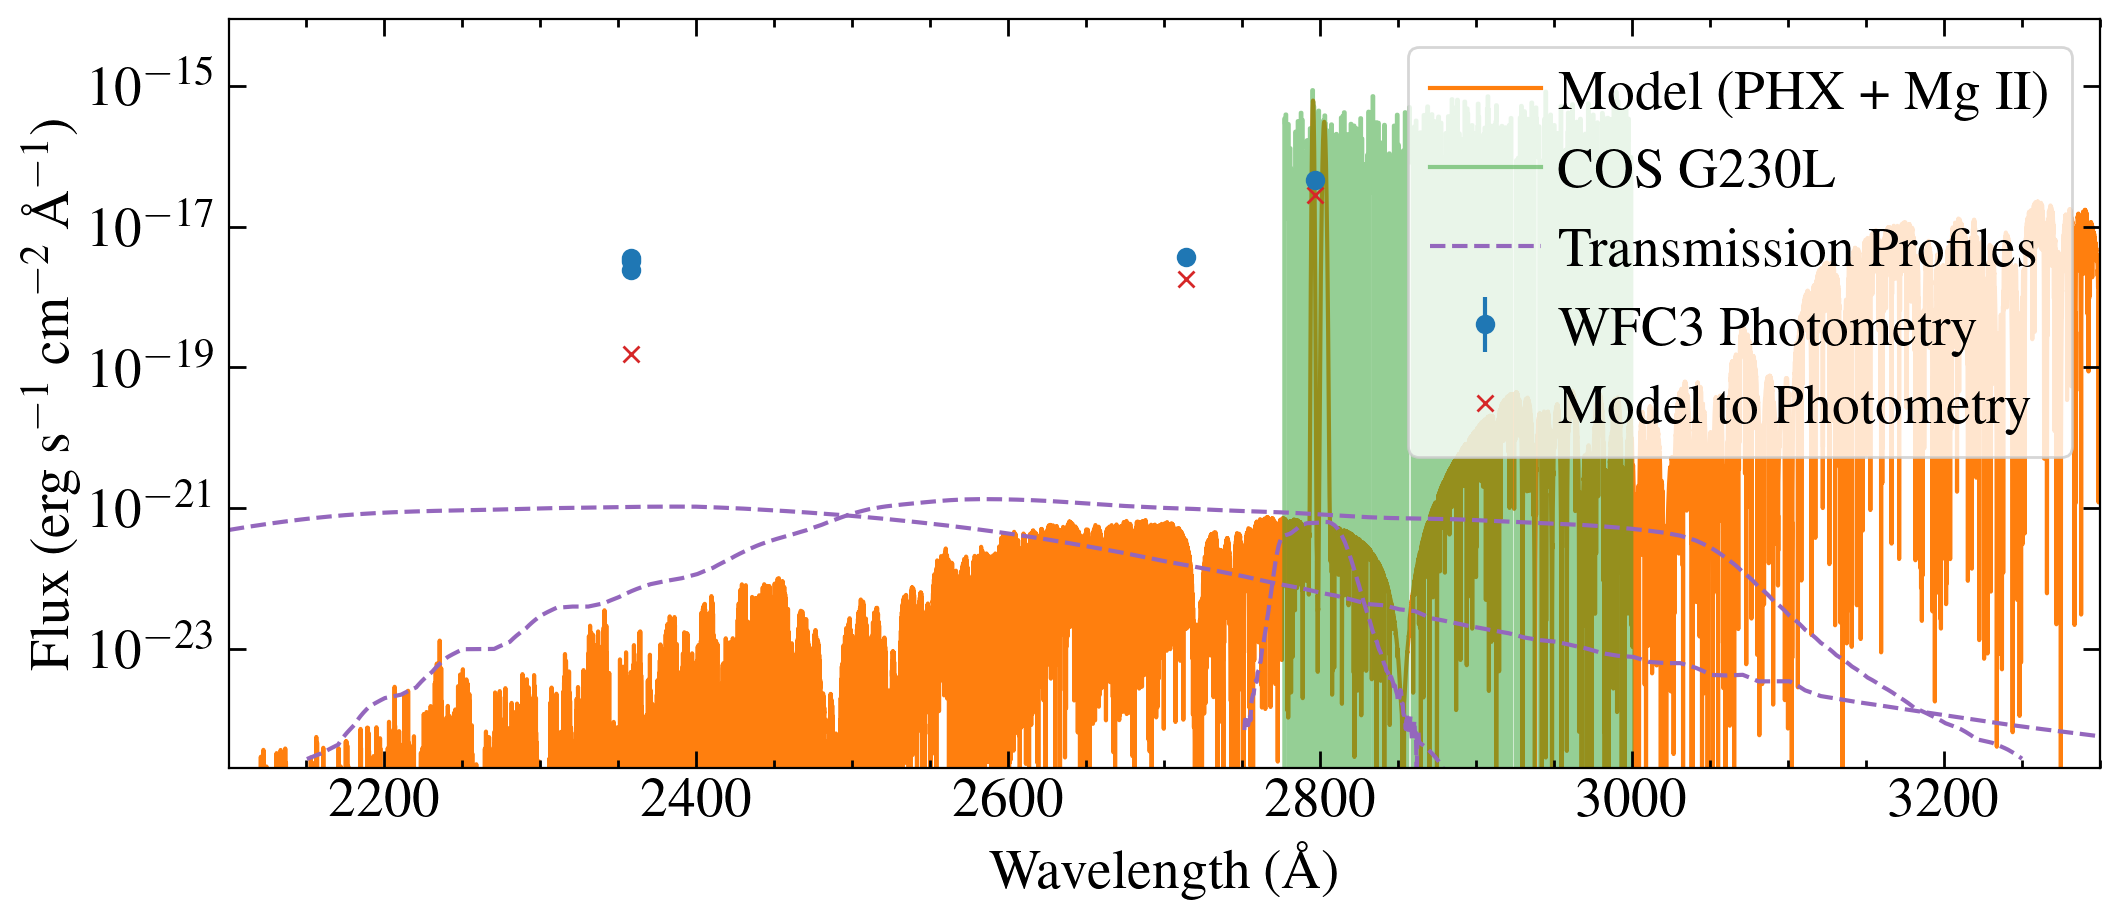

In [17]:
# print(filters, fluxes, flux_errs, np.array(fluxes)/np.array(flux_errs))
# cenwaves = [2713.86, 2796.94, 2358.70, 2358.70 , 2358.70]
# widths = np.array([471.42, 42.16, 459.87 , 459.87 , 459.87 ])

fig, ax=plt.subplots(figsize=(11, 5))

w, f = np.loadtxt('t1uv_model_v2.dat', unpack=True)
plt.plot(w, f, zorder=-1, c='C1', label ='Model (PHX + Mg II)')

plt.step(wn, fn, alpha =0.5, where='mid', zorder=-1, c='C2', label='COS G230L')
plt.errorbar(cenwaves, fluxes, yerr=flux_errs, marker='o', ls='none', label='WFC3 Photometry', zorder=10, c='C0')
plt.errorbar(phot_w, phot_f, marker='x', ls='none', label='Model to Photometry', zorder=8, c='C3')


# ax.legend(frameon=True, loc=1)
    
plt.yscale('log')
plt.ylim(2e-25, 9e-15)
plt.xlim(2101, 3300)

for band in bands:
    bpw, bpf = np.loadtxt(band, unpack=True)
    ax.plot(bpw, bpf*1e-20, ls ='--', c='C4', label = 'Transmission Profiles')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1)
    
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')

fig.tight_layout()

fig.savefig('plots/t1_wfc3_epoch3_1stlook.pdf')
fig.savefig('plots/t1_wfc3_epoch3_1stlook.png', facecolor='w')